# Machine Learning HW3

This chapter looks at the challenges of sampling observations (with replacement) when the individual samples are not Idependent and Identically Distributed (IID). This is especially true of financial data.

In the script I will compute overlapping outcomes and plot concurrent labels.

Using MFIN lab I will also compute the average uniquness of the samples and have a look at their firt-order autocorrelation.

Finally, I will fit randome forest classifier to the data and compare the out of bag accuracy versus accuracy of cross-validation.

In [377]:
# Import packages
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv

from sklearn.utils import resample, shuffle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV, KFold, train_test_split, cross_val_score
from sklearn.metrics import roc_curve, classification_report, confusion_matrix, accuracy_score
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf


# Load environment variables
load_dotenv('../config.env')

True

In [378]:
 # Import MlFinLab tools
from mlfinlab.filters import filters
from mlfinlab.labeling import labeling
from mlfinlab.sampling import concurrent, bootstrapping
from mlfinlab.util import multiprocess, volatility
from mlfinlab.data_structures.standard_data_structures import get_dollar_bars
from mlfinlab.multi_product.etf_trick import get_futures_roll_series


### Create dollar bars using SP500 Futures Data

In [379]:
#
file_path= '../Data/SP.csv'

# Load data
df = pd.read_csv(file_path)

# remove any rows where volume is 0
df = df[df['volume'] > 0]


In [380]:
# get the information of the data
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6498085 entries, 2812944 to 13802492
Data columns (total 4 columns):
 #   Column  Dtype  
---  ------  -----  
 0   date    object 
 1   time    object 
 2   price   float64
 3   volume  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 247.9+ MB


In [381]:
# convert the date column to datetime
date_time = df['date'] + ' ' + df['time']
data = pd.concat([date_time, df['price'], df['volume']], axis=1)
data.columns = ['date', 'price', 'volume']

# convert the date column to datetime
data['date'] = pd.to_datetime(data['date'])

print(data.head())
print('\n')
print('Rows:', data.shape[0])


                       date  price  volume
2812944 2003-06-30 23:00:06  971.9       1
2812945 2003-06-30 23:00:14  972.0       1
2812946 2003-06-30 23:04:16  972.0       1
2812947 2003-06-30 23:04:34  972.0       9
2812948 2003-06-30 23:05:02  972.0      91


Rows: 6498085


In [382]:
# getting the min, max, mean and median of the volume column. The numbers should be in a format with commas separating the thousands and no decimal points.
min_volume = f'{data["volume"].min():,}'
max_volume = f'{data["volume"].max():,}'
mean_volume = f'{data["volume"].mean():,.2f}'
median_volume = f'{data["volume"].median():,}'

print('Min Volume:', min_volume)
print('Max Volume:', max_volume)
print('Mean Volume:', mean_volume)
print('Median Volume:', median_volume)

Min Volume: 1
Max Volume: 4,086
Mean Volume: 1.80
Median Volume: 1.0


In [383]:
# get the max and min of the date column
min_date = data['date'].min()
max_date = data['date'].max()

print('Min Date:', min_date)
print('Max Date:', max_date)

Min Date: 2003-06-30 23:00:06
Max Date: 2019-12-31 02:21:45.011000


In [384]:
# select only the last 1 year of data from the max date
data = data[data['date'] >= '2017/01/01']


In [385]:
# view data
data.head(10)

,date,price,volume
13700659,2017-01-02 17:00:00.099,2239.7,5
13700660,2017-01-02 17:00:33.176,2243.6,1
13700661,2017-01-02 17:00:33.973,2243.6,1
13700662,2017-01-02 17:00:48.675,2244.0,1
13700663,2017-01-02 17:01:18.926,2244.0,1
13700664,2017-01-02 18:13:09.315,2243.1,1
13700665,2017-01-02 18:13:09.315,2243.2,1
13700666,2017-01-02 18:28:33.600,2240.9,1
13700667,2017-01-02 19:35:15.667,2240.4,2
13700668,2017-01-02 19:35:52.746,2240.4,1


In [386]:
# creating dollar bars
print('Creating Dollar Bars')
dollar = get_dollar_bars(data, threshold=100000,
                         batch_size=1000, verbose=True)


Creating Dollar Bars
Reading data in batches:
Batch number: 0
Batch number: 1
Batch number: 2
Batch number: 3
Batch number: 4
Batch number: 5
Batch number: 6
Batch number: 7
Batch number: 8
Batch number: 9
Batch number: 10
Batch number: 11
Batch number: 12
Batch number: 13
Batch number: 14
Batch number: 15
Batch number: 16
Batch number: 17
Batch number: 18
Batch number: 19
Batch number: 20
Batch number: 21
Batch number: 22
Batch number: 23
Batch number: 24
Batch number: 25
Batch number: 26
Batch number: 27
Batch number: 28
Batch number: 29
Batch number: 30
Batch number: 31
Batch number: 32
Batch number: 33
Batch number: 34
Batch number: 35
Batch number: 36
Batch number: 37
Batch number: 38
Batch number: 39
Batch number: 40
Batch number: 41
Batch number: 42
Batch number: 43
Batch number: 44
Batch number: 45
Batch number: 46
Batch number: 47
Batch number: 48
Batch number: 49
Batch number: 50
Batch number: 51
Batch number: 52
Batch number: 53
Batch number: 54
Batch number: 55
Batch number

In [443]:
# confirm sampling
# Confirm the dollar sampling
dollar['value'] = dollar['close'] * dollar['volume']
dollar.head(50)


,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value,value
date_time,,,,,,,,,,
2017-01-03 02:17:13.278,25,2239.7,2250.5,2239.7,2250.5,68,52,25,152764.9,153034.0
2017-01-03 02:46:14.395,33,2250.5,2251.4,2249.2,2249.2,45,22,8,101239.7,101214.0
2017-01-03 05:37:51.097,55,2249.1,2253.6,2249.1,2253.4,46,26,22,103520.2,103656.4
2017-01-03 05:50:57.365,75,2253.4,2254.9,2253.4,2254.5,46,11,20,103695.3,103707.0
2017-01-03 07:04:23.904,100,2254.5,2254.5,2252.6,2253.1,45,7,25,101425.5,101389.5
2017-01-03 08:09:18.352,118,2253.0,2253.0,2249.8,2251.1,49,11,18,110291.2,110303.9
2017-01-03 15:30:00.035,136,2251.1,2251.8,2251.0,2251.8,46,15,18,103556.0,103582.8
2017-01-03 19:56:38.315,150,2252.3,2254.7,2252.3,2254.5,46,34,14,103648.4,103707.0
2017-01-04 02:45:09.964,166,2255.5,2255.8,2254.8,2255.0,47,46,16,105999.2,105985.0


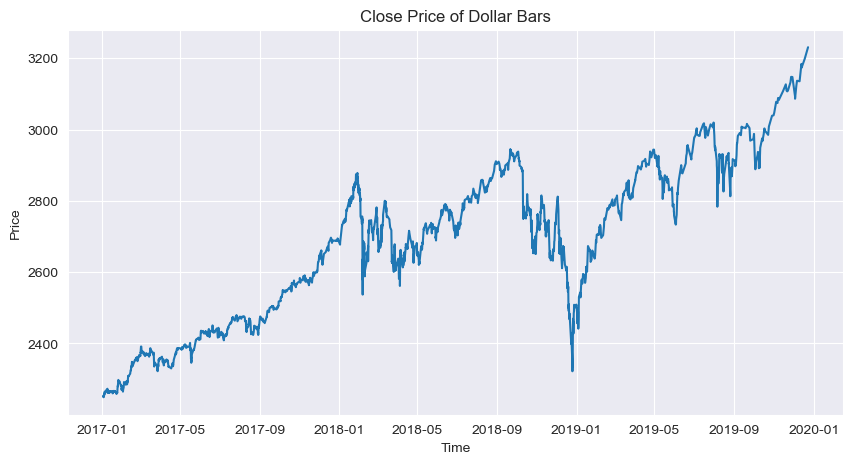

In [388]:
# plotting close price of dollar bars
plt.figure(figsize=(10, 5))
plt.plot(dollar.index, dollar['close'])
plt.title('Close Price of Dollar Bars')
plt.xlabel('Time')
plt.ylabel('Price')

# showing the plot
plt.show()


In [389]:
# creating continuous Future contract

# making a copy of  dollar, tick, volume bars
dollar_roll = dollar.copy()

# Ensure the index is a datetime object for each of the dataframes
dollar_roll.index = pd.to_datetime(dollar_roll.index)

# adding a date column to dollar_roll, tick and volume bars
dollar_roll['date'] = dollar_roll.index.date

# selecting only the columns we need for the ETF trick: 'date', 'date_time', 'close', 'open', 'high', 'low', 'volume' for each dataframe
dollar_roll = dollar_roll[['date', 'close', 'open', 'high', 'low', 'volume']]

# adding a ticker column to dollar_roll with the value 'SP' for each dataframe from above
dollar_roll['ticker'] = 'SP'

# adding a nearest_contract column to dollar_roll with the value 'SP' for each dataframe from above
dollar_roll['nearest_contract'] = 'SP'


In [390]:
# Get roll gaps (relative or absolute)

# for dollar_roll
roll_gaps_relative_dollar = get_futures_roll_series(dollar_roll, open_col='open', close_col='close',
                                                    sec_col='ticker', current_sec_col='nearest_contract', method='relative')

In [391]:
# apply the roll gaps
continuous_dollar_relative_method = dollar_roll.copy()
continuous_dollar_relative_method['close'] /= roll_gaps_relative_dollar


In [392]:
# viewing the head of continuous_contract_relative_method
continuous_dollar_relative_method.head()


,date,close,open,high,low,volume,ticker,nearest_contract
date_time,,,,,,,,
2017-01-03 02:17:13.278,2017-01-03,2250.5,2239.7,2250.5,2239.7,68,SP,SP
2017-01-03 02:46:14.395,2017-01-03,2249.2,2250.5,2251.4,2249.2,45,SP,SP
2017-01-03 05:37:51.097,2017-01-03,2253.4,2249.1,2253.6,2249.1,46,SP,SP
2017-01-03 05:50:57.365,2017-01-03,2254.5,2253.4,2254.9,2253.4,46,SP,SP
2017-01-03 07:04:23.904,2017-01-03,2253.1,2254.5,2254.5,2252.6,45,SP,SP


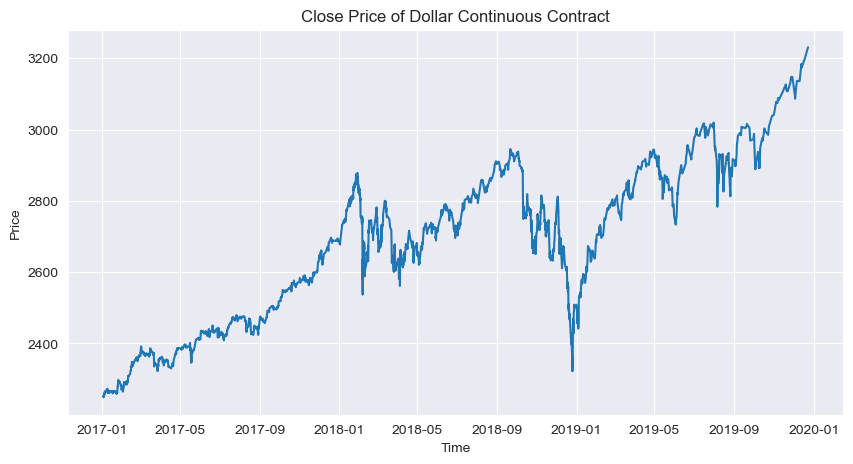

In [393]:
# plotting the close price of the continuous contract with x-axis as 'date_time' and y-axis as 'close' for each of the continuous contracts

# for dollar
plt.figure(figsize=(10, 5))
plt.plot(continuous_dollar_relative_method.index ,continuous_dollar_relative_method['close'])
plt.title('Close Price of Dollar Continuous Contract')
plt.xlabel('Time')
plt.ylabel('Price')
plt.show()


In [394]:
# rename the created dataframe to dollar_data
dollar_data = continuous_dollar_relative_method.copy()


### 4.1 In Chapter 3. we denoted as t1 a pandas series of timestamps where the first barrier was touched, and the index was the timestamp of the observation. This was the output of the getEvents.

#### 4.1 (a) Compute a t1 series on dollar bars derived from e-mini S&P 500 futures tick data

In [395]:
# view the head of dollar_data
dollar_data.head()

,date,close,open,high,low,volume,ticker,nearest_contract
date_time,,,,,,,,
2017-01-03 02:17:13.278,2017-01-03,2250.5,2239.7,2250.5,2239.7,68,SP,SP
2017-01-03 02:46:14.395,2017-01-03,2249.2,2250.5,2251.4,2249.2,45,SP,SP
2017-01-03 05:37:51.097,2017-01-03,2253.4,2249.1,2253.6,2249.1,46,SP,SP
2017-01-03 05:50:57.365,2017-01-03,2254.5,2253.4,2254.9,2253.4,46,SP,SP
2017-01-03 07:04:23.904,2017-01-03,2253.1,2254.5,2254.5,2252.6,45,SP,SP


In [396]:
# setting up data for get_events
close_prices = dollar_data['close']

#drop the NaN values from our data set
len(close_prices)

2573

In [397]:
print(close_prices.head())
print(close_prices.describe())
print('\nNo of NANs: {:}'.format(close_prices.isna().sum()))


date_time
2017-01-03 02:17:13.278    2250.5
2017-01-03 02:46:14.395    2249.2
2017-01-03 05:37:51.097    2253.4
2017-01-03 05:50:57.365    2254.5
2017-01-03 07:04:23.904    2253.1
Name: close, dtype: float64
count    2573.000000
mean     2631.279091
std       195.740054
min      2249.200000
25%      2461.700000
50%      2655.700000
75%      2779.400000
max      3230.800000
Name: close, dtype: float64

No of NANs: 0


In [398]:
# Ensure there are no missing values in the close_prices series
close_prices = close_prices.dropna()

# Align the indices of the close_prices series
close_prices = close_prices.loc[~close_prices.index.duplicated(keep='first')]

# Compute daily volatility
vol = volatility.get_daily_vol(close=close_prices, lookback=30)


In [399]:
# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(close_prices, threshold=vol.mean())


In [400]:
# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(cusum_events, close_prices, num_days=1)
vertical_barriers.head()


2017-01-08 17:14:41.218   2017-01-09 21:44:09.992
2017-01-25 02:32:01.197   2017-01-26 04:56:23.086
2017-01-30 19:25:39.949   2017-02-01 00:07:37.953
2017-02-03 07:58:05.636   2017-02-06 07:03:04.457
2017-02-09 17:13:05.432   2017-02-13 02:50:37.888
Name: date_time, dtype: datetime64[ns]

In [401]:
# Compute the triple barrier events
triple_barrier_events = labeling.get_events(close=close_prices,
                                            t_events=cusum_events,
                                            pt_sl=[1, 1],
                                            target=vol,
                                            min_ret=0.01,
                                            num_threads=1,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=None)


In [402]:
triple_barrier_events.head()

,t1,trgt,pt,sl
2018-02-05 17:01:21.802,2018-02-05 19:35:14.099,0.010407,1,1
2018-02-05 17:54:20.912,2018-02-05 19:58:27.479,0.019825,1,1
2018-02-05 19:35:14.099,2018-02-06 15:50:54.753,0.020024,1,1
2018-02-05 19:49:19.966,2018-02-06 02:46:59.289,0.021403,1,1
2018-02-05 22:18:01.270,2018-02-06 01:13:25.049,0.024242,1,1


T#### 4.1 (b) Apply the function mpNumCoEvents to compute the number of overlapping outcomes at each point in time

In [403]:
# generate the number of concurrent events
num_threads = 1
num_conc_events = multiprocess.mp_pandas_obj(concurrent.num_concurrent_events,
                                             ('molecule', triple_barrier_events.index), num_threads,
                                             close_series_index=close_prices.index,
                                             label_endtime=triple_barrier_events['t1'])

In [404]:
# Eliminate the duplicates
num_conc_events = num_conc_events.loc[~num_conc_events.index.duplicated(keep='last')]

# Reindex based on the close prices
num_conc_events = num_conc_events.reindex(close_prices.index).fillna(0)
len(num_conc_events)

2566

#### 4.1 (c) Plot the time-series of the number of concurrent labels on the primary axis, and the time series of exponentially weighted moving standard deviation of returns on the secondary axis

In [405]:
display_df = (pd.DataFrame().assign(vol=vol,
                                    num_conc_events=num_conc_events)
              .drop_duplicates()
              .dropna())

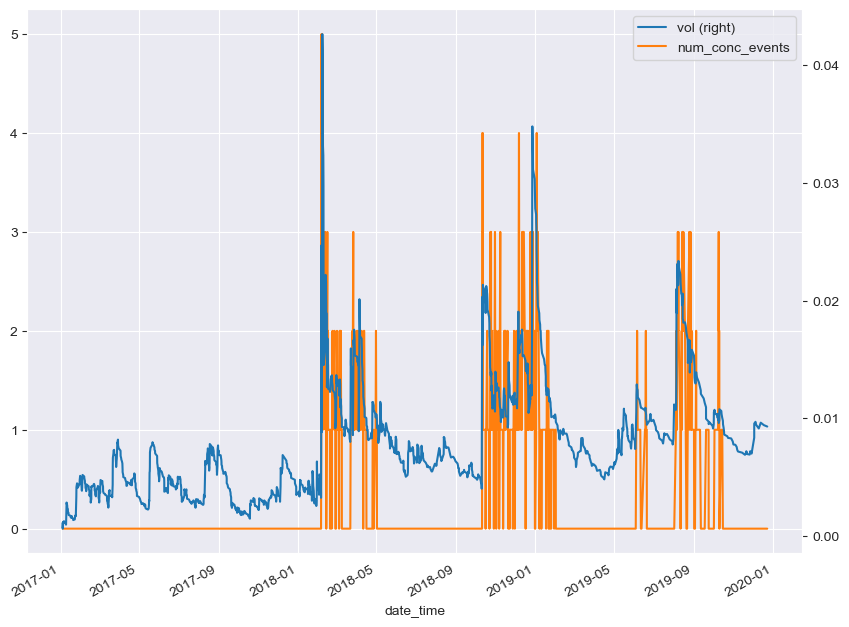

In [406]:
# display_df.plot()
display_df[['vol', 'num_conc_events']].plot(secondary_y='vol', figsize=(10,8))
plt.show()

#### 4.1 (d) Produce a scatterplot of the number of concurrent labels (x-axis) and the exponentially weighted moving standard deviation of returns (y-axis). Can you appreciate the relationship?

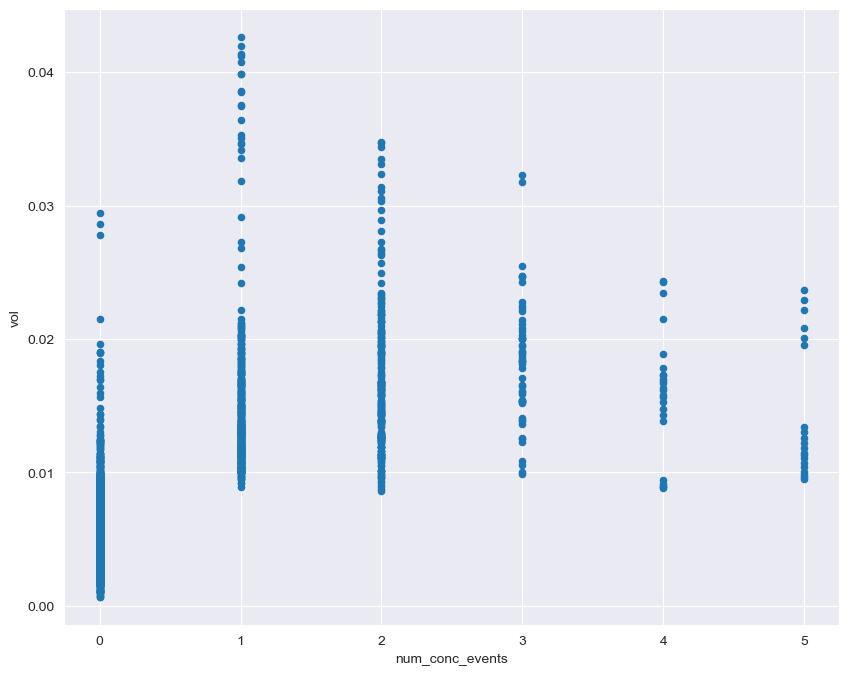

In [407]:
display_df.plot.scatter(x='num_conc_events', y='vol', figsize=(10, 8))
plt.show()

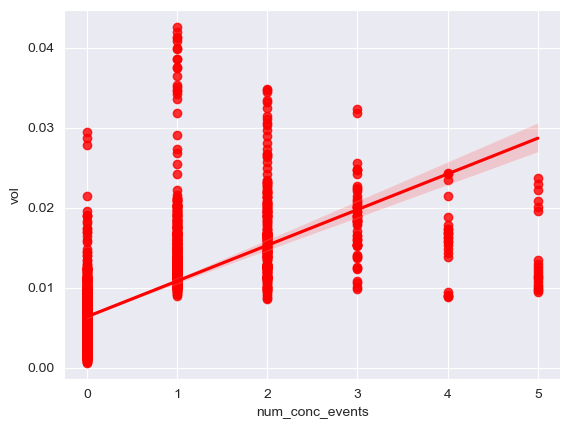

In [408]:
sns.regplot(x=display_df['num_conc_events'], y=display_df['vol'], color='r')
plt.show()

In [409]:
# Try polyfit
x = display_df['num_conc_events']
y = display_df['vol']
z = np.polyfit(x, y, 2)
p = np.poly1d(z)

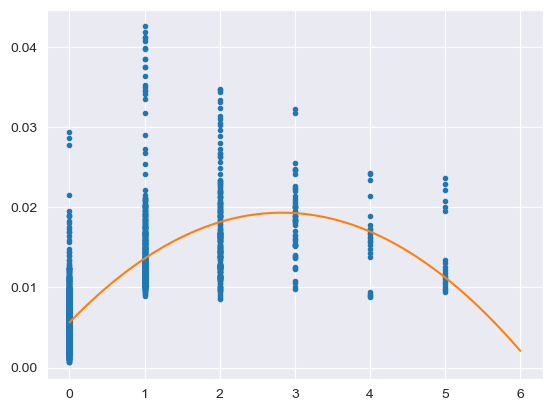

In [410]:
xp = np.linspace(0, max(x)+1, 100)
_ = plt.plot(x, y, '.', xp, p(xp), '-')

### 4.2 Using thefunction mpSampleTW, compute the average uniqueness of each label. What is the first-order serial correlation, AR(1), of this time series? Is it statistically significant? Why?

In [411]:
# Compute the average uniqueness of each label

out = multiprocess.mp_pandas_obj(concurrent._get_average_uniqueness, ('molecule', triple_barrier_events.index), num_threads,
                                 label_endtime=triple_barrier_events['t1'], num_conc_events=num_conc_events)

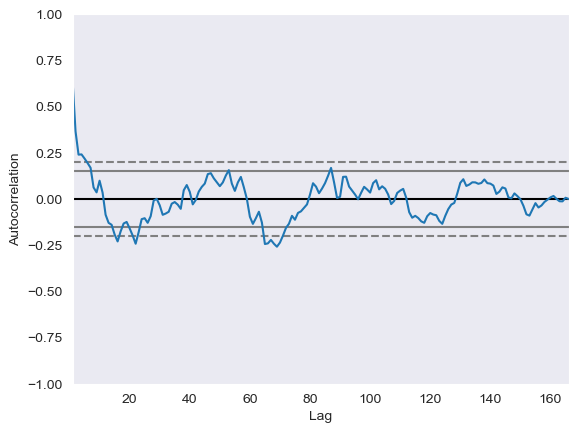

In [412]:
# ACF plot
pd.plotting.autocorrelation_plot(out);

/Users/karolk/anaconda3/envs/ML_Fin/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


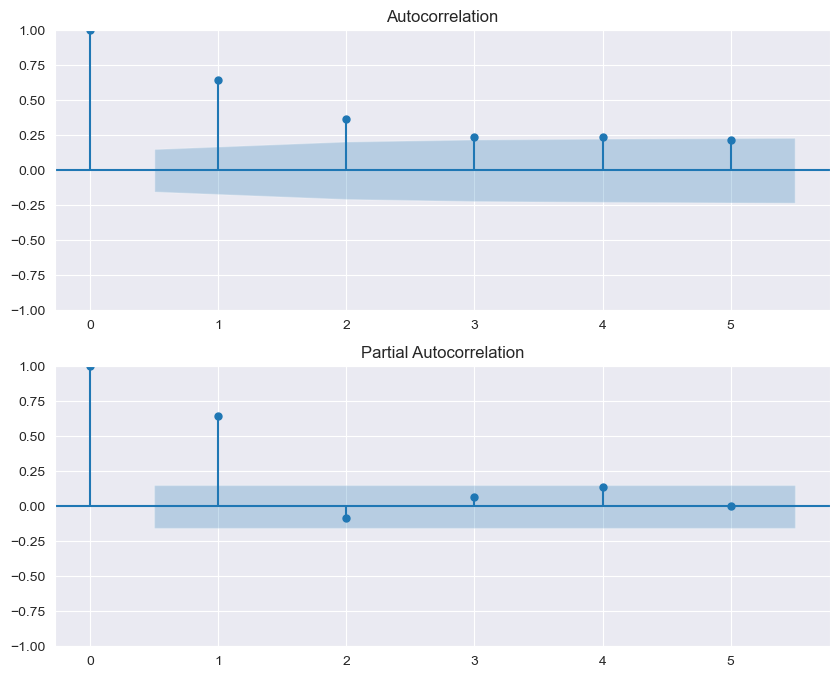

In [413]:
plt.figure(figsize=(10, 8))
plt.subplot(211)
plot_acf(out, ax=plt.gca(), lags=5)
plt.subplot(212)
plot_pacf(out, ax=plt.gca(), lags=5)
plt.show()

### 4.3 Fit a random forest to a financial data set where the average uniqueness is de minimis

In [414]:
# creating a smaller dataframe for machine learning

# making a copy of dollar_data
data = dollar_data.copy()

# defining start date and end date for the data
start_date = '2019-01-01'
end_date = '2019-12-31'

# filtering the data for the start and end date
data = data[(data.index >= start_date) & (data.index <= end_date)]

# dropping the ticker and nearest_contract columns
data = data.drop(columns=['ticker', 'nearest_contract'])

# viewing the head of the data
data.head()


,date,close,open,high,low,volume
date_time,,,,,,
2019-01-02 00:25:16.628,2019-01-02,2484.8,2509.4,2518.6,2477.0,40
2019-01-02 01:48:41.395,2019-01-02,2479.5,2483.0,2483.0,2476.6,41
2019-01-02 02:23:24.164,2019-01-02,2459.6,2478.2,2478.3,2454.5,41
2019-01-02 02:51:38.817,2019-01-02,2456.5,2457.7,2458.1,2454.2,41
2019-01-02 07:34:15.893,2019-01-02,2462.4,2454.6,2476.1,2454.6,42


In [415]:
close_prices = data['close']

#### 4.3 (a) What is the mean out-of-bag accuracy?

In [416]:
# defining RSI
# Compute RSI
def relative_strength_index(df, n):
    """
    Calculate Relative Strength Index(RSI) for given data.
    https://github.com/Crypto-toolbox/pandas-technical-indicators/blob/master/technical_indicators.py

    :param df: (pd.DataFrame) Frame of data to use.
    :param n: (int) RST to use.
    :return: (pd.DataFrame) Resulting RSI.
    """

    i = 0
    UpI = [0]
    DoI = [0]

    while i + 1 <= df.index[-1]:
        UpMove = df.loc[i + 1, 'high'] - df.loc[i, 'high']
        DoMove = df.loc[i, 'low'] - df.loc[i + 1, 'low']
        if UpMove > DoMove and UpMove > 0:
            UpD = UpMove
        else:
            UpD = 0
        UpI.append(UpD)
        if DoMove > UpMove and DoMove > 0:
            DoD = DoMove
        else:
            DoD = 0
        DoI.append(DoD)
        i = i + 1

    UpI = pd.Series(UpI)
    DoI = pd.Series(DoI)
    PosDI = pd.Series(UpI.ewm(span=n, min_periods=n).mean())
    NegDI = pd.Series(DoI.ewm(span=n, min_periods=n).mean())
    RSI = pd.Series(round(PosDI * 100. / (PosDI + NegDI)), name='RSI_' + str(n))
    # df = df.join(RSI)

    return RSI

def get_rsi(data, window=14):
    """
    Wrapper around the relative_strength_index function.
    """

    df = data.copy(deep=True).reset_index()
    rsi = relative_strength_index(df, window)
    rsi_df = pd.Series(data=rsi.values, index=data.index)

    return rsi_df

In [417]:
# defining Bollinger Bands

def bbands(close_prices, window, no_of_stdev):
    """
    Apply Bollinger Bands to the series.
    """

    rolling_mean = close_prices.ewm(span=window).mean()
    rolling_std = close_prices.ewm(span=window).std()

    upper_band = rolling_mean + (rolling_std * no_of_stdev)
    lower_band = rolling_mean - (rolling_std * no_of_stdev)

    return rolling_mean, upper_band, lower_band

In [418]:
# Compute bands
window = 50
data['avg'], data['upper'], data['lower'] = bbands(data['close'], window, no_of_stdev=0.5)
data.sample(10)

,date,close,open,high,low,volume,avg,upper,lower
date_time,,,,,,,,,
2019-08-05 15:31:15.931,2019-08-05,2831.3,2893.6,2900.3,2830.1,35,2926.036343,2959.761172,2892.311514
2019-08-09 03:04:31.718,2019-08-09,2925.5,2929.7,2929.7,2924.8,39,2898.162247,2930.108685,2866.215809
2019-01-02 17:50:27.000,2019-01-02,2472.7,2491.3,2494.0,2472.4,41,2475.907976,2483.698525,2468.117426
2019-11-14 18:58:07.154,2019-11-14,3107.5,3091.4,3107.5,3077.4,33,2984.001757,3018.556696,2949.446818
2019-01-24 02:14:25.995,2019-01-24,2634.5,2634.1,2646.9,2628.5,38,2601.459172,2632.646068,2570.272275
2019-08-13 04:09:33.016,2019-08-13,2878.5,2886.7,2887.5,2873.5,35,2898.789665,2928.606973,2868.972357
2019-05-08 19:30:51.017,2019-05-08,2880.1,2880.1,2884.1,2878.3,35,2875.942242,2903.525520,2848.358965
2019-01-13 17:01:05.735,2019-01-13,2589.9,2595.1,2595.7,2582.7,39,2528.552486,2554.097182,2503.007790
2019-08-15 06:31:13.936,2019-08-15,2850.9,2826.8,2863.6,2819.3,36,2890.395961,2918.271291,2862.520632


In [419]:
# Compute RSI
rsi_df = get_rsi(data, window=14)
data['rsi'] = pd.Series(data=rsi_df.values, index=data.index)

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)

In [420]:
# Compute sides
data['side'] = np.nan

long_signals = (data['close'] <= data['lower'])
short_signals = (data['close'] >= data['upper'])

data.loc[long_signals, 'side'] = 1
data.loc[short_signals, 'side'] = -1

print(data.side.value_counts())

# Remove Look ahead bias by lagging the signal
data['side'] = data['side'].shift(1)

side
-1.0    221
 1.0     61
Name: count, dtype: int64


In [421]:
# Save the raw data
raw_data = data.copy()

# Drop the NaN values from our data set
data.dropna(axis=0, how='any', inplace=True)
print(data.side.value_counts())

side
-1.0    220
 1.0     61
Name: count, dtype: int64


In [422]:
# Compute daily volatility
daily_vol = volatility.get_daily_vol(close=data['close'], lookback=10)

# Apply Symmetric CUSUM Filter and get timestamps for events
# Note: Only the CUSUM filter needs a point estimate for volatility
cusum_events = filters.cusum_filter(data['close'], threshold=daily_vol.mean() * 0.1)

# Compute vertical barrier
vertical_barriers = labeling.add_vertical_barrier(t_events=cusum_events, close=data['close'], num_days=1)


In [423]:
pt_sl = [0, 2]
triple_barrier_events = labeling.get_events(close=data['close'],
                                            t_events=cusum_events,
                                            pt_sl=pt_sl,
                                            target=daily_vol,
                                            num_threads=2,
                                            vertical_barrier_times=vertical_barriers,
                                            side_prediction=data['side'])

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


2025-03-31 14:24:36.572031 100.0% apply_pt_sl_on_t1 done after 0.08 minutes. Remaining 0.0 minutes.


In [424]:
# Averge uniqueness
avg_uniqueness = concurrent.get_av_uniqueness_from_triple_barrier(triple_barrier_events, close_prices, num_threads=1)
print(avg_uniqueness.mean())

tW    0.42948
dtype: float64


In [425]:
labels = labeling.get_bins(triple_barrier_events, data['close'])
labels.side.value_counts()

side
-1.0    167
 1.0     55
Name: count, dtype: int64

Features

In [426]:

# Log Returns
raw_data['log_ret'] = np.log(raw_data['close']).diff()

# Momentum
raw_data['mom1'] = raw_data['close'].pct_change(periods=1)
raw_data['mom2'] = raw_data['close'].pct_change(periods=2)
raw_data['mom3'] = raw_data['close'].pct_change(periods=3)
raw_data['mom4'] = raw_data['close'].pct_change(periods=4)
raw_data['mom5'] = raw_data['close'].pct_change(periods=5)

# Volatility
window_stdev = 10
raw_data['volatility'] = raw_data['log_ret'].rolling(window=window_stdev, min_periods=window_stdev, center=False).std()

# Serial Correlation (Takes about 4 minutes)
window_autocorr = 10

raw_data['autocorr_1'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=1), raw=False)
raw_data['autocorr_2'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=2), raw=False)
raw_data['autocorr_3'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=3), raw=False)
raw_data['autocorr_4'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=4), raw=False)
raw_data['autocorr_5'] = raw_data['log_ret'].rolling(window=window_autocorr, min_periods=window_autocorr, center=False).apply(lambda x: x.autocorr(lag=5), raw=False)

# Get the various log -t returns
raw_data['log_t1'] = raw_data['log_ret'].shift(1)
raw_data['log_t2'] = raw_data['log_ret'].shift(2)
raw_data['log_t3'] = raw_data['log_ret'].shift(3)
raw_data['log_t4'] = raw_data['log_ret'].shift(4)
raw_data['log_t5'] = raw_data['log_ret'].shift(5)

# Add fast and slow moving averages
fast_window = 7
slow_window = 15

raw_data['fast_mavg'] = raw_data['close'].rolling(window=fast_window, min_periods=fast_window, center=False).mean()
raw_data['slow_mavg'] = raw_data['close'].rolling(window=slow_window, min_periods=slow_window, center=False).mean()

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [427]:
# Add Trending signals
raw_data['sma'] = np.nan

long_signals = raw_data['fast_mavg'] >= raw_data['slow_mavg']
short_signals = raw_data['fast_mavg'] < raw_data['slow_mavg']
raw_data.loc[long_signals, 'sma'] = 1
raw_data.loc[short_signals, 'sma'] = -1


In [428]:
# Re compute sides
raw_data['side'] = np.nan

long_signals = raw_data['close'] <= raw_data['lower']
short_signals = raw_data['close'] >= raw_data['upper']

raw_data.loc[long_signals, 'side'] = 1
raw_data.loc[short_signals, 'side'] = -1


In [429]:
# Remove look ahead bias
raw_data = raw_data.shift(1)
raw_data.head(5)

,date,close,open,high,low,volume,avg,upper,lower,rsi,...,autocorr_4,autocorr_5,log_t1,log_t2,log_t3,log_t4,log_t5,fast_mavg,slow_mavg,sma
date_time,,,,,,,,,,,,,,,,,,,,,
2019-01-04 03:07:04.478,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04 07:31:27.563,2019-01-04,2471.7,2439.7,2471.7,2439.6,49.0,2473.858045,2481.775120,2465.940970,28.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-04 15:35:05.504,2019-01-04,2474.5,2471.7,2485.3,2471.1,41.0,2473.913836,2481.460817,2466.366855,40.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-06 19:30:05.328,2019-01-04,2530.5,2475.9,2530.5,2470.8,41.0,2478.607761,2489.429392,2467.786130,64.0,...,NaN,NaN,0.001132,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2019-01-07 03:30:43.802,2019-01-06,2543.2,2530.8,2550.2,2529.0,43.0,2483.741284,2497.476801,2470.005768,70.0,...,NaN,NaN,0.022379,0.001132,NaN,NaN,NaN,NaN,NaN,NaN


Now get the data at the specified events

In [430]:
# Get features at event dates
X = raw_data.loc[labels.index, :]


In [431]:
# unique columns of X
unique_cols = X.columns.unique()

unique_cols

Index(['date', 'close', 'open', 'high', 'low', 'volume', 'avg', 'upper',
       'lower', 'rsi', 'side', 'log_ret', 'mom1', 'mom2', 'mom3', 'mom4',
       'mom5', 'volatility', 'autocorr_1', 'autocorr_2', 'autocorr_3',
       'autocorr_4', 'autocorr_5', 'log_t1', 'log_t2', 'log_t3', 'log_t4',
       'log_t5', 'fast_mavg', 'slow_mavg', 'sma'],
      dtype='object')

In [432]:
# Drop unwanted columns
X.drop(['avg', 'upper', 'lower', 'open', 'high', 'low', 'close', 'fast_mavg', 'slow_mavg', 'date'], axis=1, inplace=True)

In [433]:
# Drop columns with NaN values
X.dropna(axis=0, how='any', inplace=True)

# define y
y = labels['bin'].copy()

# droping any y which are not in X
y = y.loc[X.index]

In [434]:
# checking the shape of X and y
print(X.shape)
print(y.shape)

(214, 21)
(214,)


Fitting a model

In [435]:
# Split data into training, validation and test sets
X_training_test = X
y_training_test = y
X_train, X_test, y_train, y_test = train_test_split(X_training_test, y_training_test, test_size=0.2, shuffle=False)


In [436]:
train_df = pd.concat([y_train, X_train], axis=1, join='inner')
train_df['bin'].value_counts()

bin
1    89
0    82
Name: count, dtype: int64

In [437]:
# Create training data
y_train = train_df['bin']
X_train= train_df.loc[:, train_df.columns != 'bin']

In [438]:
# extract parameters
n_estimator = 100
depth = 5
c_random_state = 42
print(n_estimator, depth, c_random_state)

100 5 42


In [439]:
# Random Forest Model
rf = RandomForestClassifier(max_depth=depth, n_estimators=n_estimator, oob_score=True,
                            criterion='entropy', random_state=c_random_state)
rf.fit(X_train, y_train.values.ravel())
print("Out-of-bag Accuracy (OOB Score): {:.6f}".format(rf.oob_score_))


Out-of-bag Accuracy (OOB Score): 0.619883


*The out of bag accuracy in a data-set that has low uniqueness is 62% ... commenting on observations with low uniquness, section 4.5 of AFML, page 63 states, "random sampling will make out-of-bag examples very similar to in-the-bag ones, the OOB accuracy would be grossly inflated"*

#### 4.3 (b) what is the mean accuracy of k-fold cross-validation (without shuffling) on the same dataset?

In [440]:
# K-fold
no_of_folds = 10
kfold = KFold(shuffle=True, random_state=1, n_splits=no_of_folds)
print(kfold)

KFold(n_splits=10, random_state=1, shuffle=True)


In [441]:
accuracy_array = np.zeros(no_of_folds)
i = 0
for train_index, test_index in kfold.split(X_training_test):
    # print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X.iloc[train_index], X.iloc[test_index]
    y_train, y_test = y.iloc[train_index], y.iloc[test_index]
    rf.fit(X_train, y_train.values.ravel())

    y_pred_rf = rf.predict_proba(X_test)[:, 1]
    y_pred = rf.predict(X_test)
    accuracy_array[i] = accuracy_score(y_test, y_pred)
    i += 1
    # print(accuracy_score(y_test, y_pred))

In [442]:
print(accuracy_array)
print("Mean KFold accuracy: {:.6f}".format(np.mean(accuracy_array)))

[0.59090909 0.5        0.68181818 0.68181818 0.66666667 0.61904762
 0.42857143 0.66666667 0.52380952 0.52380952]
Mean KFold accuracy: 0.588312


*The mean accuracy from KFold is 59% - the same as the OOB accuracy score. The OOB score is more biased because in case of sampling with replacement, there is higher redundancy within the in-the-bag observations. This in turn causes overestimation of accuracy.*